In [1]:
import earthkit as ekt
import pygrib
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

In [7]:
model = 'gfs-test'
gribFile = rf'data/gribs/{model.lower()}/latest/{model.lower()}-latest.grb2'
#gribFile = rf'data/gribs/{model.lower()}/maxmin/{model.lower()}-036.grb2'
ds = ekt.data.from_source('file', gribFile)


In [ ]:
grbs = pygrib.open(gribFile)
for grb in grbs:
    print(grb)

In [18]:
print(ds.ls())

   centre shortName        typeOfLevel  level  dataDate  dataTime stepRange  \
0    kwbc     prmsl            meanSea      0  20241206      1200        30   
1    kwbc      refc         atmosphere      0  20241206      1200        30   
2    kwbc        gh      isobaricInhPa    500  20241206      1200        30   
3    kwbc        gh      isobaricInhPa   1000  20241206      1200        30   
4    kwbc        2t  heightAboveGround      2  20241206      1200        30   
5    kwbc       10u  heightAboveGround     10  20241206      1200        30   
6    kwbc       10v  heightAboveGround     10  20241206      1200        30   
7    kwbc        tp            surface      0  20241206      1200     24-30   
8    kwbc        tp            surface      0  20241206      1200      0-30   
9    kwbc     csnow            surface      0  20241206      1200        30   
10   kwbc     cicep            surface      0  20241206      1200        30   
11   kwbc     cfrzr            surface      0  20241

In [8]:
steps = []
for ts in ds:
    #print(ts.ls())
    #print('name ', ts.metadata('name'), 'param num ', ts.metadata('parameterNumber'))
    #print('step ', ts.metadata('step'))
    step = ts.metadata('step')
    if step not in steps:
        steps.append(step)

print(steps)



[30]


In [ ]:
for step in steps:
    ts = ds.sel(step=step, stepType='instant')
    ts = ts.sel(shortName = ['cfrzr', 'csnow', 'cicep', 'refc', 'prmsl', 'gh'])
    print(ts.ls())

In [31]:
step = 30
ts = ds.sel(step=step, stepType='instant')
ts = ts.sel(shortName = ['cfrzr', 'csnow', 'cicep', 'refc', 'prmsl', 'gh'])

prmsl = ts.sel(shortName = 'prmsl')
refc = ts.sel(shortName = 'refc')
csnow = ts.sel(shortName = 'csnow')[0]
cicep = ts.sel(shortName = 'cicep')[0]
cfrzr = ts.sel(shortName = 'cfrzr')[0]
gh1000 = ts.sel(shortName = 'gh', level=1000)
gh500 = ts.sel(shortName = 'gh', level=500)
refc_np = refc.to_numpy()
csnow_np = csnow.to_numpy()
cfrzr_np = cfrzr.to_numpy()
cicep_np = cicep.to_numpy()
gh1000_np = gh1000.to_numpy()
gh500_np = gh500.to_numpy()
refc_snow = np.squeeze(np.where(csnow_np == 1, refc_np, 0) + 100)
refc_ice = np.squeeze(np.where((cfrzr_np == 1) | (cicep_np == 1), refc_np, 0) + 200)
thk1000_500 = gh500_np - gh1000_np

refc_snow_field = ts[0].clone(values=refc_snow)
refc_ice_field = ts[0].clone(values=refc_ice)
thk1000_500_field = ts[0].clone(values=thk1000_500)


In [34]:
print(thk1000_500_field.values)

[5007.48175 5007.48175 5007.48175 ... 5109.58175 5109.58175 5109.58175]


In [ ]:
import matplotlib.colors as mcolors

color_values_refc = {
    5: '#FFFFFF00',
    10: '#00FF0088',
    20: 'green',
    30: 'yellow',
    40: 'orange',
    50: 'red',
    60: 'purple',
    70: 'pink',
    80: 'orange'
}

# Create the normalized bounds (0 to 1) for the colormap
""" norm = mcolors.Normalize(vmin=min(color_values_refc.keys()), vmax=max(color_values_refc.keys()))
# Create a LinearSegmentedColormap
cmap_refc = mcolors.LinearSegmentedColormap.from_list(
    'colormap_refc',
    [(norm(value), color) for value, color in color_values_refc.items()]
) """

norm = mcolors.BoundaryNorm(
    boundaries=list(color_values_refc.keys()),
    ncolors=len(color_values_refc),
    extend='neither' )

values = list(color_values_refc.values())
levels = list(color_values_refc.keys())
print(levels)
print(values)
cmap = mcolors.ListedColormap(values)

norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, extend='neither')

color_values_refc_snow = {
    105: '#FFFFFF00',
    110: '#0000FF88',
    120: 'aqua',
    130: 'blue',
    140: 'purple',
    150: 'pink',
    160: 'white',
    170: 'green',
    180: 'orange'
}

# Create the normalized bounds (0 to 1) for the colormap
""" norm = mcolors.Normalize(vmin=min(color_values_refc.keys()), vmax=max(color_values_refc.keys()))
# Create a LinearSegmentedColormap
cmap_refc = mcolors.LinearSegmentedColormap.from_list(
    'colormap_refc',
    [(norm(value), color) for value, color in color_values_refc.items()]
) """

norm_snow = mcolors.BoundaryNorm(
    boundaries=list(color_values_refc_snow.keys()),
    ncolors=len(color_values_refc_snow),
    extend='neither' )

values_snow = list(color_values_refc_snow.values())
levels_snow = list(color_values_refc_snow.keys())
print(levels_snow)
print(values_snow)
cmap_snow = mcolors.ListedColormap(values_snow)

norm_snow = mcolors.BoundaryNorm(levels_snow, ncolors=cmap_snow.N, extend='neither')

color_values_refc_ice = {
    205: '#FFFFFF00',
    210: '#FF000088',
    220: 'red',
    230: 'yellow',
    240: 'green',
    250: 'brown',
    260: 'white',
    270: 'blue',
    280: 'black'
}

# Create the normalized bounds (0 to 1) for the colormap
""" norm = mcolors.Normalize(vmin=min(color_values_refc.keys()), vmax=max(color_values_refc.keys()))
# Create a LinearSegmentedColormap
cmap_refc = mcolors.LinearSegmentedColormap.from_list(
    'colormap_refc',
    [(norm(value), color) for value, color in color_values_refc.items()]
) """

norm_ice = mcolors.BoundaryNorm(
    boundaries=list(color_values_refc_ice.keys()),
    ncolors=len(color_values_refc_ice),
    extend='neither' )

values_ice = list(color_values_refc_ice.values())
levels_ice = list(color_values_refc_ice.keys())
print(levels_ice)
print(values_ice)
cmap_ice = mcolors.ListedColormap(values_ice)

norm_ice = mcolors.BoundaryNorm(levels_ice, ncolors=cmap_ice.N, extend='neither')

STYLE = ekt.plots.styles.Style(
    colors="Spectral_r",
    levels=range(15, 33),
    #units="celsius",
    ticks=range(15, 33),
)
levels_mslp = np.linspace(88000,108000,51)
levels_thk = np.linspace(4500,6120, 28)

STYLE_THK = ekt.plots.styles.Style(levels=levels_thk, colors='purple', extend='neither')
STYLE_MSLP = ekt.plots.styles.Style(levels=levels_mslp, colors='k', extend='neither')
STYLE = ekt.plots.styles.Style(levels=levels, cmap=cmap, extend='neither')
STYLE_SNOW = ekt.plots.styles.Style(levels=levels_snow, cmap=cmap_snow, extend='neither', legend_style='None')
STYLE_ICE = ekt.plots.styles.Style(levels=levels_ice, cmap=cmap_ice, extend='neither', legend_style='None')

[5, 10, 20, 30, 40, 50, 60, 70, 80]
['#FFFFFF00', '#00FF0088', 'green', 'yellow', 'orange', 'red', 'purple', 'pink', 'orange']
[105, 110, 120, 130, 140, 150, 160, 170, 180]
['#FFFFFF00', '#0000FF88', 'aqua', 'blue', 'purple', 'pink', 'white', 'green', 'orange']
[205, 210, 220, 230, 240, 250, 260, 270, 280]
['#FFFFFF00', '#FF000088', 'red', 'yellow', 'green', 'brown', 'white', 'blue', 'black']


In [11]:
import os
print(os.getcwd())
shapefile_path = "data/geo/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
shapefile_path_lakes = "data/geo/ne_110m_lakes/ne_110m_lakes.shp"
# Read the shapefile using Cartopy's Shapereader
shape_data = shpreader.Reader(shapefile_path)
shape_data_lakes = shpreader.Reader(shapefile_path_lakes)
# Extract features from the shapefile
states = ShapelyFeature(shape_data.geometries(), ccrs.PlateCarree(), facecolor="none", edgecolor="none")
lakes = ShapelyFeature(shape_data_lakes.geometries(), ccrs.PlateCarree(), facecolor="none", edgecolor="none")

/home/jeff/modelgen


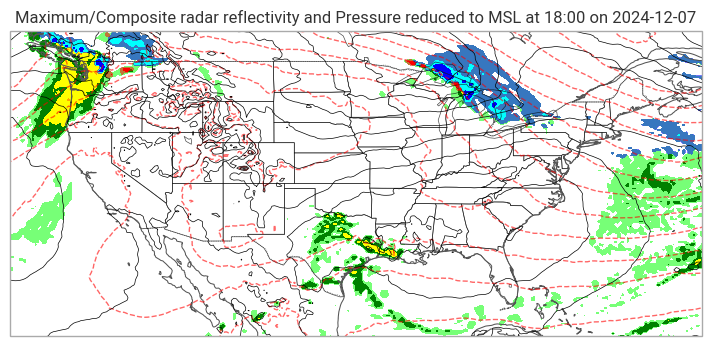

In [41]:
domain_bounds = [-130,-62,22,52]
#domain_bounds = [-140,-60,20,90]
crs = ccrs.PlateCarree()
#chart = earthkit.plots.Map(domain="CONUS")
chart = ekt.plots.Map(domain=domain_bounds, crs=crs)
chart.contourf(refc, style=STYLE)
chart.contourf(refc_snow_field, style=STYLE_SNOW)
chart.contourf(refc_ice_field, style=STYLE_ICE)
chart.contour(thk1000_500_field, style=STYLE_THK, linewidths=1, linestyles='dashed', alpha=0.6)
chart.contour(prmsl, style=STYLE_MSLP, linewidths=0.5)


#chart.contour(pressure, units="hPa")
chart.shapes(states,  transform=ccrs.PlateCarree(), adjust_labels=False, labels=False, facecolor="none",  # No fill color
    edgecolor="black",  # Blue outline
    linewidth=0.5,     # Line thickness
    alpha=0.7)
chart.shapes(lakes,  transform=ccrs.PlateCarree(), adjust_labels=False, labels=False, facecolor="none",  # No fill color
    edgecolor="black",  # Blue outline
    linewidth=0.5,     # Line thickness
    alpha=0.7)
#chart.legend(location="bottom")

chart.coastlines()
chart.borders()
#chart.urban_areas()
chart.title()
#chart.gridlines()


chart.show()

In [ ]:
print(dir(chart))

In [ ]:
dsm = ds[12].metadata()
print(dir(dsm))
keys = dsm.keys()
for key in list(keys):
    print(key)

In [ ]:
ds1.metadata('parameterNumber')

In [27]:
levels_thk = np.linspace(45000,61200, 28)
print(levels_thk)

[45000. 45600. 46200. 46800. 47400. 48000. 48600. 49200. 49800. 50400.
 51000. 51600. 52200. 52800. 53400. 54000. 54600. 55200. 55800. 56400.
 57000. 57600. 58200. 58800. 59400. 60000. 60600. 61200.]


In [22]:
(61200-45000)/600

27.0